# ML Pipeline Preparation


### Import libraries and load data


In [36]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import make_scorer, classification_report, f1_score
from sklearn.externals import joblib
# from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words'])
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# pipeline caching
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.utils import Memory

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(); color='rebeccapurple'
%matplotlib inline  

# display settings
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_columns', None)  

import time
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-dat

In [2]:
# load data from database with `read_sql_table`
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages', engine)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25992 entries, 0 to 25991
Data columns (total 39 columns):
id                        25992 non-null int64
message                   25992 non-null object
original                  10021 non-null object
genre                     25992 non-null object
related                   25992 non-null int64
request                   25992 non-null int64
offer                     25992 non-null int64
aid_related               25992 non-null int64
medical_help              25992 non-null int64
medical_products          25992 non-null int64
search_and_rescue         25992 non-null int64
security                  25992 non-null int64
military                  25992 non-null int64
water                     25992 non-null int64
food                      25992 non-null int64
shelter                   25992 non-null int64
clothing                  25992 non-null int64
money                     25992 non-null int64
missing_people            25992 non-null i

## Split data into training and test sets (with stratified sampling)
Based on the results of the EDA (documented in separate `EDA.ipynb`) stratfied sampling is used for splitting into training and test set. The proportion of the different _numbers of active categories per message_ is to be preserved.

In [4]:
# create new column with total number of active categories per message
df['total'] = df.iloc[:,4:40].sum(axis=1)
# for StratifiedShuffleSlpit to work properly all values > 10 in ['total'] column will be set to 11. (Kind of oultier removal.)
df['total'] = np.where((df['total'] >10), 11, df['total'])

In [5]:
# create testset with stratified sampling according to the category count per message
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 111)
for train_index, test_index in split.split(df, df['total']):
    train = df.loc[train_index]
    test = df.loc[test_index]
    
# safety-check
assert np.abs(len(test) - (len(df) * 0.2)) <= 1, 'split got messed up'
assert (round(df['related'].sum() / len(df),3)) == (round(train['related'].sum() / len(train),3)), 'not properly stratisfied'

In [6]:
# remove 'total' column from train and test sets
for set_ in (train, test):
    set_.drop('total', axis=1, inplace=True)
    
# safety-check
assert len(test.columns) == 39

## Split into features an target variables

In [7]:
X_train = train['message'].values
Y_train = train.iloc[:, 4:39].values

X_test = test['message'].values
Y_test = test.iloc[:, 4:39].values

In [8]:
#check
X_train[:2]

array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'Good evening to all USA soldiers. we still suffer from this great event. We would love to handle your presence of authority. thank you'],
      dtype=object)

In [9]:
#check
Y_train[:2]

array([[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

## Preprocessing

### Define tokenization function

In [13]:
def tokenize_text(message):
    """Tokenization function to process text data. """
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize case and remove punctuation
    message = re.sub(r"[^a-zA-Z0-9]", " ", message.lower())
    # tokenize text
    tokens = word_tokenize(message)
    # lemmatize, stip and remove stop words
    tokens = [lemmatizer.lemmatize(word.strip()) for word in tokens if word not in stop_words]
    # add part-of-speech tags
    tokens = pos_tag(tokens)
    
    return tokens

In [11]:
# check
for message in X_train[:2]:
    tokens = tokenize_text(message)
    print(message)
    print(tokens, '\n')

Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.
[('2', 'CD'), ('000', 'CD'), ('woman', 'NN'), ('protesting', 'VBG'), ('conduct', 'NN'), ('election', 'NN'), ('teargassed', 'VBD'), ('tried', 'JJ'), ('converge', 'NN'), ('local', 'JJ'), ('electoral', 'JJ'), ('commission', 'NN'), ('office', 'NN'), ('southern', 'JJ'), ('oil', 'NN'), ('city', 'NN'), ('port', 'NN'), ('harcourt', 'NN')] 

Good evening to all USA soldiers. we still suffer from this great event. We would love to handle your presence of authority. thank you
[('good', 'JJ'), ('evening', 'NN'), ('usa', 'NN'), ('soldier', 'NN'), ('still', 'RB'), ('suffer', 'VBZ'), ('great', 'JJ'), ('event', 'NN'), ('would', 'MD'), ('love', 'VB'), ('handle', 'VB'), ('presence', 'NN'), ('authority', 'NN'), ('thank', 'NN')] 



### Build preprocessing pipeline

In [12]:
# define the classifier, wrapped in MultiOutputClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

# build the pipeline
pre_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
              ])

start = time.time()


X_train = pre_pipe.fit_transform(X_train)
# train the pipeline
# X_train = pipe.fit(X_train, Y_train)
# # predict labels on test_set
# Y_pred = model.predict(X_test)

print('Duration: {} seconds'.format(time.time() - start))

Duration: 45.003615617752075 seconds


### Test different baseline models

Evaluation of different possible classifiers, Validation with stratified k-fold CV. Models are:
- LogisticRegression 
- RandomForestClassifier 
- XGBClassifier
- SVC

To handle the multi-labels they are wrapped into scikit-learn's [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) ([example here](https://scikit-learn.org/stable/modules/multiclass.html#multioutput-classification)).
The scorer for the model comparision is f1-score with weighted average, taking the feature imbalance into account.


In [10]:
classifiers = {'LogReg' :MultiOutputClassifier(LogisticRegression(solver='liblinear')),
               'Random Forest' : MultiOutputClassifier(RandomForestClassifier(n_estimators=50)),
               'Gradient Boosting' : MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50)),
                }

scorer = make_scorer(f1_score, average='weighted')

In [14]:
# for each model, fit to train set and validate with stratified 3-fold CV, store results in nested dict

def compare_models(model_dict, X_train, y_train, scorer, cv=StratifiedKFold(3)):
    """Fit defined models to the train set and cross validate the results. 
       (This Funcion is built on top of sk-learn's cross_validate function.)
              
       ARGUMENTS:
       model_dict: dict of names (k) and sk-learn model objects (v)
       X_train: training features (df or array)
       y_train: training labels (df or array)
       scorer: evaluation metric for validation
       cv: type of CV, default is StratifiedKFold(3)

       
       RETURNS:
       results: dataframe with metrics.
"""
    # store results of cross_validate in nested dict
    results = {}
    
    for name, model in tqdm(model_dict.items()):
        try:  # standard type for data input is df
            name = name
            scores = cross_validate(
                model, X_train, y_train, cv=cv, error_score='raise', 
                n_jobs=-1, scoring=scorer, return_train_score=False, 
                return_estimator=True
            )
        except:  # exception for classifiers that need data as array
            name = name
            scores = cross_validate(
                model, X_train.toarray(), y_train, cv=cv, 
                error_score='raise', n_jobs=-1,
                scoring=scorer, return_train_score=False, 
                return_estimator=True
            )
        
        results[name] = scores
    
    # create dataframe with extra metrics (95_conf, total_time)
    results = pd.DataFrame(results).T
    results['estimator'] = results['estimator'].apply(lambda x: x[0])
    results['95_conf'] = \
        results['test_score'].apply(lambda x: np.std(x) * 2)
    for col in results.iloc[:,1:]:
        results[col] = results[col].apply(lambda x: np.mean(x))
    results['total_time'] = results['score_time'] + results['fit_time']
    results = results[['estimator', 'test_score', '95_conf', 
                  'total_time', 'fit_time', 'score_time']]
    
    return results

In [15]:
# define a function for plotting the main results of the model comparision
def plot_comparision(results):
    """Plot copmarision of test scores and run times for cross validated
       models.
       
       ARGUMENTS:
       results: dataframe generated with 'compare_models' function.
       """
    data = results.sort_values(by='test_score', ascending=False)
    plt.figure(figsize=(18,6));
    plt.subplot(1,2,1)
    # plot the mean test scores
    sns.barplot(x='test_score', y=data.index, data=data, color="rebeccapurple")
    plt.xlabel(scorer);
    plt.subplot(1,2,2)
    # Plot the mean total time
    sns.set_color_codes("pastel")
    sns.barplot(x="total_time", y=data.index, data=data,
        label="Total", color="rebeccapurple")
    # Plot the mean fit time
    sns.set_color_codes("muted")
    sns.barplot(x='fit_time', y=data.index, data=data,
        label="Fit", color="yellow")
    plt.xlabel("Time for fitting (yellow) and scoring (purple)");

In [16]:
eval_results = compare_models(classifiers, X_train, Y_train, scorer, cv=3)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [33:38<00:00, 511.05s/it]


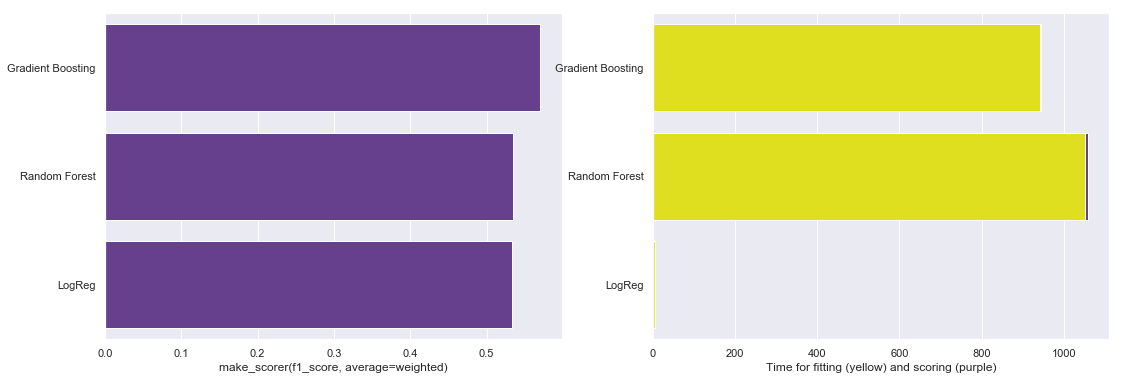

In [20]:
plot_comparision(eval_results)

In [17]:
eval_results

,estimator,test_score,95_conf,total_time,fit_time,score_time
LogReg,"MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='liblinear',\n tol=0.0001, verbose=0, warm_start=False),\n n_jobs=None)",0.533876,0.004504,4.652886,4.377956,0.274931
Random Forest,"MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,\n oob_score=False, random_state=None, verbose=0,\n warm_start=False),\n n_jobs=None)",0.534072,0.009138,1058.259256,1052.088836,6.170421
Gradient Boosting,"MultiOutputClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_sampl... subsample=1.0, tol=0.0001, validation_fraction=0.1,\n verbose=0, warm_start=False),\n n_jobs=None)",0.569825,0.008401,943.742876,943.293222,0.449654


In [33]:
# testing two additional classifiers
classifiers_2 = {'NB' : MultiOutputClassifier(MultinomialNB()),
               'LinSVC' : MultiOutputClassifier(SGDClassifier(loss='hinge', class_weight='balanced')),
                }

eval_results_2 = compare_models(classifiers_2, X_train, Y_train, scorer, cv=3)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


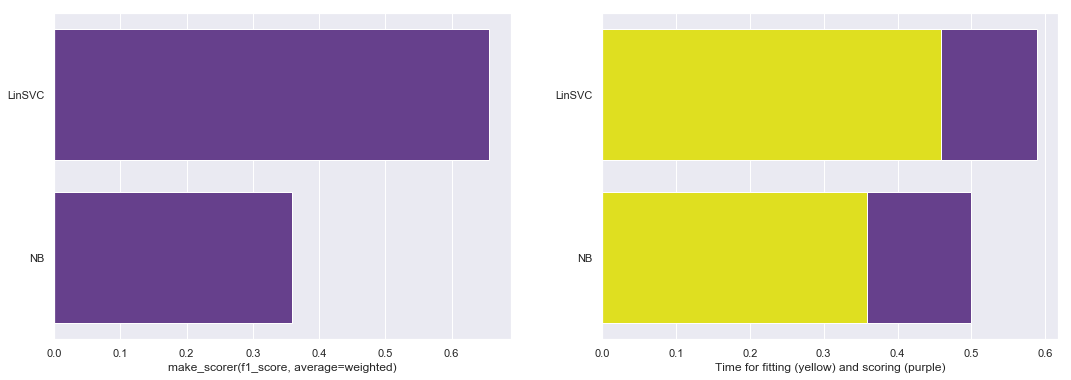

In [34]:
plot_comparision(eval_results_2)

In [35]:
eval_results_2

,estimator,test_score,95_conf,total_time,fit_time,score_time
NB,"MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),\n n_jobs=None)",0.358754,0.003940,0.499883,0.359297,0.140586
LinSVC,"MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',\n early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,\n n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',\n power_t=0.5, random_state=None, shuffle=True, tol=None,\n validation_fraction=0.1, verbose=0, warm_start=False),\n n_jobs=None)",0.656381,0.007546,0.588407,0.458228,0.130179


__Observation / Decision:__ Linear SVC (SGD with loss='hinge') scores best and will be further tuned for final modelling.

## Build full Pipeline and Improve Model with GridSearchCV

In [27]:
# define the classifier
clf = SGDClassifier(max_iter=5, tol=None, random_state=1, n_jobs=-1)

def optimize_model(clf, X_train, y_train, scorer, cv=StratifiedKFold(3)):
    """Build a full nlp classification pipeline with GridSearchCV
       for best parameters.
    
    ARGUMENTS:
        clf: classifier (sk-learn model object)
        X_train: training features (df or array)
        y_train: training labels (df or array)
        scorer: evaluation metric for validation
        cv: type of CV, default is StratifiedKFold(3)
        
    RETURNS:
        full_grid: grid search object
        tuned_model: estimator with highest score
    """
    
    # create temporary folder to store pipeline transformers (cache)
    cachedir = mkdtemp()
    memory = Memory(location=cachedir, verbose=10)
    
    full_pipe = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize_text)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(clf))],
        memory=memory)

    parameters = {
#         'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__min_df': [1, 5],
        'tfidf__use_idf': (True, False),
        'clf__estimator__alpha': [0.0001, 0.001, 0.01],
        }
    

    start = time.time()

    # create grid search object
    cv = GridSearchCV(full_pipe, param_grid=parameters, 
            scoring=scorer, cv=cv, error_score='raise', 
            n_jobs=1, verbose=1)
    full_grid = cv.fit(X_train, Y_train) 

    return full_grid

    # delete the temporary cache before exiting
    rmtree(cachedir)

    print('Duration: {} seconds'.format(time.time() - start))

In [28]:
full_grid = optimize_model(clf, X_train, Y_train, scorer, cv=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Khotang is a key eastern stronghold of the ultra-leftist guerrillas, whose power is concentrated in the west.',
       ...,
       'I favorited a YouTube video Dog Senses Arcata Earthquake at News Station http youtu.be NzBnyRDwQxE?a'],
      dtype=object), 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.46s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 30.8s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x30936 sparse matrix of type '<class 'numpy.int64'>'
	with 195084 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       ...,
       'I favorited a YouTube video Dog Senses Arcata Earthquake at News Station http youtu.be NzBnyRDwQxE?a'],
      dtype=object), 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), No

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.40s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 30.9s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x30868 sparse matrix of type '<class 'numpy.int64'>'
	with 192166 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       ...,
       'Subsidised fodder distributions have been carried out, fodder banks set up in some areas and seeds successfully distributed in anticipation of the monsoon rains.'],
      dtype=object), 
array([[

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 32.0s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x31023 sparse matrix of type '<class 'numpy.int64'>'
	with 192918 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Khotang is a key eastern stronghold of the ultra-leftist guerrillas, whose power is concentrated in the west.',
       ...,
       'I favorited a YouTube video Dog Senses Arcata Earthquake at News Station http youtu.be NzBnyRDwQxE?a'],
      dtype=object), 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 0.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 29.4s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x5566 sparse matrix of type '<class 'numpy.int64'>'
	with 158461 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       ...,
       'I favorited a YouTube video Dog Senses Arcata Earthquake at News Station http youtu.be NzBnyRDwQxE?a'],
      dtype=object), 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), No

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 0.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 28.9s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x5519 sparse matrix of type '<class 'numpy.int64'>'
	with 155780 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       ...,
       'Subsidised fodder distributions have been carried out, fodder banks set up in some areas and seeds successfully distributed in anticipation of the monsoon rains.'],
      dtype=object), 
array([[

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 29.1s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <13862x5473 sparse matrix of type '<class 'numpy.int64'>'
	with 156030 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\66d2998447bf978657a8a4bc935bf828
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x30936 sparse matrix of type '<class 'numpy.int64'>'
	with 195084 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0968558274673b6922fa115f866d06e1
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x30868 sparse matrix of type '<class 'numpy.int64'>'
	with 192166 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\6cfc63e6b63c313828dc9c8f41b38ec0
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x31023 sparse matrix of type '<class 'numpy.int64'>'
	with 192918 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3e69d528af16359e9e52a45f679ecb79
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x5566 sparse matrix of type '<class 'numpy.int64'>'
	with 158461 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 1],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9a00020b50d450ec48475d1ce28471d1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x5519 sparse matrix of type '<class 'numpy.int64'>'
	with 155780 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3fb6e58e499c400a97700e9ca37a388d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<13862x5473 sparse matrix of type '<class 'numpy.int64'>'
	with 156030 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\66d2998447bf978657a8a4bc935bf828
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\f6676e56a7df03704d786bf0a7611984
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0968558274673b6922fa115f866d06e1
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9277a6d934a357f4ffef909845e3e563
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\6cfc63e6b63c313828dc9c8f41b38ec0
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\207cbc977fddceb02b4b16fbce2b51de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3e69d528af16359e9e52a45f679ecb79
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\d82bcd9ca9c9c2fb44e7ff80bf0df441
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9a00020b50d450ec48475d1ce28471d1
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\7df1d1588b3ba5222fd8863c93bb6d23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3fb6e58e499c400a97700e9ca37a388d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\d130a769b65690a56dce2bd03ab00bdb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\66d2998447bf978657a8a4bc935bf828
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\ad25c4f52f8df0b691f20bf1d21099de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0968558274673b6922fa115f866d06e1
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\71b44375d65bbf2c0fbc8aed467b281e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\6cfc63e6b63c313828dc9c8f41b38ec0
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\8bba634a9fc14c18e79c33ea1863e9aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3e69d528af16359e9e52a45f679ecb79
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\115661e8b13485247f7d7ff5e7d83d18
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9a00020b50d450ec48475d1ce28471d1
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0cf59db9405ae4d8f4e5a88f65819537
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3fb6e58e499c400a97700e9ca37a388d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\fb0155bdfcae264797f31b60e9a0bdb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\66d2998447bf978657a8a4bc935bf828
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\f6676e56a7df03704d786bf0a7611984
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0968558274673b6922fa115f866d06e1
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9277a6d934a357f4ffef909845e3e563
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\6cfc63e6b63c313828dc9c8f41b38ec0
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\207cbc977fddceb02b4b16fbce2b51de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3e69d528af16359e9e52a45f679ecb79
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\d82bcd9ca9c9c2fb44e7ff80bf0df441
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9a00020b50d450ec48475d1ce28471d1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\7df1d1588b3ba5222fd8863c93bb6d23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3fb6e58e499c400a97700e9ca37a388d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\d130a769b65690a56dce2bd03ab00bdb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\66d2998447bf978657a8a4bc935bf828
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\ad25c4f52f8df0b691f20bf1d21099de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0968558274673b6922fa115f866d06e1
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\71b44375d65bbf2c0fbc8aed467b281e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\6cfc63e6b63c313828dc9c8f41b38ec0
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\8bba634a9fc14c18e79c33ea1863e9aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3e69d528af16359e9e52a45f679ecb79
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\115661e8b13485247f7d7ff5e7d83d18
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\9a00020b50d450ec48475d1ce28471d1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\0cf59db9405ae4d8f4e5a88f65819537
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\3fb6e58e499c400a97700e9ca37a388d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\r2d4\AppData\Local\Temp\tmp0se19kea\joblib\sklearn\pipeline\_fit_transform_one\fb0155bdfcae264797f31b60e9a0bdb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 30.7min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_text at 0x00000234F8B668C8>,
        vocabulary=None), 
array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       ...,
       'I favorited a YouTube video Dog Senses Arcata Earthquake at News Station http youtu.be NzBnyRDwQxE?a'],
      dtype=object), 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), No

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 4.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 44.3s, 0.7min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False,
         use_idf=False), 
<20793x39226 sparse matrix of type '<class 'numpy.int64'>'
	with 290084 stored elements in Compressed Sparse Row format>, 
array([[1, ..., 0],
       ...,
       [1, ..., 0]], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


In [29]:
# return best params
full_grid.best_params_

{'clf__estimator__alpha': 0.0001, 'tfidf__use_idf': False, 'vect__min_df': 1}

In [30]:
# return best score
full_grid.best_score_

0.6015670098077412

In [34]:
# return best model
tuned_clf = full_grid.best_estimator_

### Safe the tuned model


In [37]:
joblib.dump(tuned_clf, 'tuned_clf.pkl')
print("Model saved.")

# tuned_clf = joblib.load('tuned_clf.pkl')
# print("Model loaded.")

Model saved.


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [39]:
def evaluate_multilabel(model, X_test, y_test):
    """Calculate evaluation metrics for ML model
    
    ARGUMENTS:
    Y_real: Array containing actual labels.
    Y_pred: Array containing predicted labels.
       
    RETURNS:
    metrics_df: Dataframe containing the multilabel
    classification report.
    """
    
    y_pred = model.predict(X_test)
    
    # create list of strings with target class names
    target_names = train.iloc[:, (-1 * y_test.shape[1]):].columns
    
    # Calculate classification report
    metrics = classification_report(
                y_test, y_pred,
                target_names=target_names,
                output_dict=True,
                )

    # Create dataframe, tanspose it
    metrics_df = pd.DataFrame(
                    data = metrics, 
                    ).T
      
    return metrics_df

In [40]:
evaluate_multilabel(tuned_clf, X_test, Y_test)

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


,f1-score,precision,recall,support
related,0.893236,0.840355,0.953219,3976.0
request,0.624741,0.801418,0.511891,883.0
offer,0.000000,0.000000,0.000000,32.0
aid_related,0.690560,0.767246,0.627811,2179.0
medical_help,0.223853,0.743902,0.131749,463.0
medical_products,0.234940,0.812500,0.137324,284.0
search_and_rescue,0.202247,0.782609,0.116129,155.0
security,0.000000,0.000000,0.000000,85.0
military,0.110553,0.611111,0.060773,181.0
water,0.679803,0.726316,0.638889,324.0


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

- to do: concatenate one hot encoded genre with text
- eventually length and total categories to (see blog article)

In [ ]:
stop

# define the classifier, wrapped in MultiOutputClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

# build the pipeline
pre_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(clf, n_jobs=-1)),
              ])

start = time.time()

# train the pipeline
model = pipe.fit(X_train, Y_train)
# predict labels on test_set
Y_pred = model.predict(X_test)

print('Duration: {} seconds'.format(time.time() - start))